# Assignment 1

## The Costs of Economic Nationalism

> Group members: Alexandros Gilch, Paul Grass, Julius Kappenberg, Daniel Nogues Kollert, Tim Mensinger, Philipp Schirmer

This tasks aims to examine the _short-run_ effects of Brexit on GDP. To do so we employ the synthetic control method (Abadie, 2010). In particular we construct a _synthetic_ counterfactual of Britain which can then be used to compare Britain with and without Brexit. The _synthetic_ Britain is constructed as a weighted average of all other european countries where the weights are set to minimize pre-treatment period moments. The rest of this notebook is structured as follows: In section 1 we implement the synthetic control method from scratch. This is done since available packages for R/Python did not seem trustworthy or simply poorly written. This part can be safely skipped by everyone not interested in the implementation. In section 2 we apply the method to our problem and consider robustness checks. Section 3 concludes.

> Remark. The tradeoff of using a fully reproducible* notebook is that shown code can seem obstrusive. We choose this style nevertheless since we believe that the added value of results that are easy to reproduce plus the fact that the reader may directly check the code which produced a graph outweighs a less readable document. *Reproducible given data and Python environment.

## 1 Code

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial
from estimagic import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

sns.set_style("whitegrid")

### 1.1 Data Preparation

In [2]:
country_names = [
    "Australia",
    "Austria",
    "Belgium",
    "Canada",
    "Chile",
    "Czech Rep",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Ireland",
    "Israel",
    "Italy",
    "Japan",
    "Korea",
    "Luxembourg",
    "Mexico",
    "Netherlands",
    "New Zealand",
    "Norway",
    "Portugal",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Switzerland",
    "US",
    "GB",
]

country_names_dict = {i + 1: name for i, name in enumerate(country_names)}

In [3]:
df = pd.read_excel("data/mydata.xlsx")  # change this path if necessary
df = df.assign(**{"name": df.country.replace(country_names_dict)})
df = df.set_index(["quarter", "name"]).sort_index()
df = df.drop("country", axis=1)

In [4]:
df.head()

loggdp
quarter name               
1       Australia -0.016800
        Austria   -0.010487
        Belgium   -0.008201
        Canada    -0.001922
        Chile     -0.039199

### 1.2 Synthetic Control Method Functions

In [5]:
def prepare_data(data, treatment_period, treated_country):
    """Return dependent and independent data to be used in model.
    
    Args:
        data (pandas.DataFrame): The data frame with multiindex ["quarter", "name"]
            and one column containing values.
        treatment_period (int): The treatment period corresponding to a value in
            levelindex "quarter" of data.
        treated_country (str): The treated country unit corresponding to a value in
            levelindex "name" of data.
    
    Returns:
        y (pandas.Series): The dependent values with multiindex ["quarter", "name"].
        X (pandas.DataFrame): The independent feature matrix with index "quarter"
            and columns corresponding to "name".
    
    """
    y = df.loc[: treatment_period - 1, treated_country, :]
    y = y[y.columns[0]]
    X = df.loc[: treatment_period - 1, :, :].query("name != @treated_country")
    X = X.unstack().droplevel(0, axis=1)
    return y, X

In [6]:
def get_crit_func(y, X, weights, loss_type):
    """Get criterion function which will be optimized.
    
    This function takes in data in form of y, X returned by 
    :func:``prepare_data``as well as the loss function type and
    weights (weighting matrix V in model) and return the criterion
    function which depends only on the country weights. This
    function can then be passed to a standard optimizer to find
    optimal weights.
    
    Args:
        y (pandas.Series or numpy.ndarray[1d]): Dependent values.
        X (pandas.DataFrame or numpy.ndarray[2d]): Independent valeus.
        weights (numpy.ndarray[1d] or numpy.ndarray[2d]): Weighting array or
            weighting matrix. Has shape (len(y), len(y)).
        loss_type (str): Loss function type. Currently implemented are
            ["squared_error", "absolute_error"].
            
    Returns:
        crit_func (callable): The criterion function with single input.
    
    """

    def crit(params, y, X, loss_type):
        w = np.asarray(params["value"])
        if loss_type == "squared_error":
            loss = mean_squared_error
        elif loss_type == "absolute_error":
            loss = mean_absolute_error
        else:
            raise ValueError(
                "Loss type not implemented, must be in {'squared_error', 'absolute_error'}"
            )
        return loss(y, X @ w, sample_weight=weights)

    crit_func = partial(crit, y=y, X=X, loss_type=loss_type)
    return crit_func

In [7]:
def synthetic_control(
    data,
    treatment_period,
    treated_country,
    loss_type="squared_error",
    weights=None,
    algorithm="scipy_lbfgsb",
):
    """Apply synthetic control method to our setting.
    
    Args:
        data (pandas.DataFrame): The data frame with multiindex ["quarter", "name"]
            and one column containing values.
        treatment_period (int): The treatment period corresponding to a value in
            levelindex "quarter" of data.
        treated_country (str): The treated country unit corresponding to a value in
            levelindex "name" of data.
        weights (numpy.ndarray[1d] or numpy.ndarray[2d]): Weighting array or
            weighting matrix. Has shape (len(y), len(y)).
        loss_type (str): Loss function type. Currently implemented are
            ["squared_error", "absolute_error"].
        algorithm (str): Which algorithm to choose for optimization. See implemented
            algorithms in estimagic.
        
    Returns:
        result_params (pandas.DataFrame): Result params data frame with index
            corresponding country names and value column corresponding to the
            country weights.
    
    """
    # build crit func
    y, X = prepare_data(data, treatment_period, treated_country)

    crit_func = get_crit_func(y.values, X.values, weights, loss_type)

    # build params start vector
    x0 = np.ones((X.shape[1], 1))
    params = pd.DataFrame(x0, index=X.columns, columns=["value"]) / X.shape[1]
    params = params.assign(**{"type": "weight"})
    params = params.reset_index().set_index(["type", "name"])

    # build constraint dict
    constraints = [{"loc": "weight", "type": "probability"}]

    # optimize
    result = minimize(crit_func, params, algorithm=algorithm, constraints=constraints)

    result_params = result["solution_params"][["value"]]
    return result_params

### 1.3 Plotting Functions

In [8]:
def plot_results(
    data,
    result,
    treatment_period,
    periods=None,
    ylim=None,
    caption=None,
    return_results=False,
):
    """Plot results from synthetic control method.
    
    Plots true and synthetic country time series as well as all donors. Donors
    are given a transparency parameter corresponding to the weight to which
    they contribute to the synthetic country.
    
    Args:
        data (pandas.DataFrame): The data frame with multiindex ["quarter", "name"]
            and one column containing values.
        result (pandas.DataFrame): Results returned from :func:``synthetic_control``.
        treatment_period (int): The treatment period corresponding to a value in
            levelindex "quarter" of data.
        periods (list-like): Number of periods to plot.
        ylim (tuple[2d]): y-axis limits of plot.
        caption (str): Caption under plot.

    Returns:
        None
    
    """
    # preparation
    if periods is not None:
        data = data.query("quarter in @periods")

    treated_country = (
        set(data.index.get_level_values("name"))
        - set(result.index.get_level_values("name"))
    ).pop()
    X = data.unstack().droplevel(0, axis=1)
    synthetic = X.drop(treated_country, axis=1).dot(result.droplevel(0))

    df = X.assign(**{"treated": X[treated_country], "synthetic": synthetic})
    df = df.reset_index().melt(id_vars="quarter", value_name="loggdp")

    alpha = result.droplevel(0)
    alpha.loc["treated", "value"] = 1
    alpha.loc["synthetic", "value"] = 1

    df = df.merge(alpha.reset_index().rename({"value": "alpha"}, axis=1))

    # plotting
    fig, ax = plt.subplots(1)
    fig.set_size_inches(16, 12)

    p = sns.lineplot(
        x="quarter",
        y="loggdp",
        data=df.query("name in ['treated', 'synthetic']"),
        hue="name",
        ax=ax,
    )

    for country_name in df.name.unique():
        if country_name not in ["treated", "synthetic"]:
            _data = df.query("name == @country_name")
            sns.lineplot(
                x="quarter",
                y="loggdp",
                data=_data,
                alpha=_data["alpha"].unique()[0] * 2,
                ax=ax,
            )

    ax.axvline(treatment_period, color="grey", linestyle="--")
    scaler = ylim[1] * 3 / 4 if ylim is not None else 1
    ax.text(treatment_period, 1.05 * scaler, "Treatment Period", fontsize=14, ha="left")

    if ylim is not None:
        ax.set_ylim(ylim)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set(ylabel="Log-GDP", xlabel="Quarter")
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)

    # write difference in plot
    fd = df.query("name in ['synthetic', 'treated']").set_index(["quarter", "name"])[
        "loggdp"
    ]
    diff = fd.loc[fd.idxmax()[0], :].diff().abs().dropna()[0]

    ax.legend(
        loc="upper left",
        bbox_to_anchor=(0.07, 0.75),
        frameon=False,
        labels=[
            f"Treated Country: {treated_country}",
            f"Synthetic. (Diff. on last period: {diff:.3f})",
        ],
        prop={"size": 14},
    )

    return None

## 2 Application

### 2.1 Results

We start by considering all data points from 1995 until the Brexit referendum. To achieve a better fit we do not minimize squared-error but absolute-error. Furthermore we weigh the 5 periods before the treatment period to achieve a closer fit between true Britain and synthetic Britain at the treatment period. Note that this is in line with the method which explicitly includes a weighting matrix. Note further that there is **no** weighting matrix which is uninformative in the Bayesian sense. Even a uniform weighting matrix makes an assumption about the structure of the problem. Hence our response to a question why we &mdash;arbitrarily one may argue&mdash; weigh the last 5 periods more is: Why not?

In [9]:
treated_country = "GB"
treatment_period = 87

weights = np.ones(treatment_period - 1)
weights[-5 : treatment_period - 1] = 10

In [10]:
result = synthetic_control(
    df, treatment_period, treated_country, loss_type="absolute_error", weights=weights
)

The two plots below compare Britain with its synthetic counterpart over the time-series. The second plot zooms in on the periods closer to the treatment period. The first plot shows that synthetic Britain follows the trajectory of true Britain very closely. However, after the treatment period the trajectories part ways with synthetic Britain continuing its trend while true Britain falls short. Under a multitude of assumptions one may argue that this is a causal effect. In the following subsection we provide robustness checks to strengthen the argument of a causal effect.

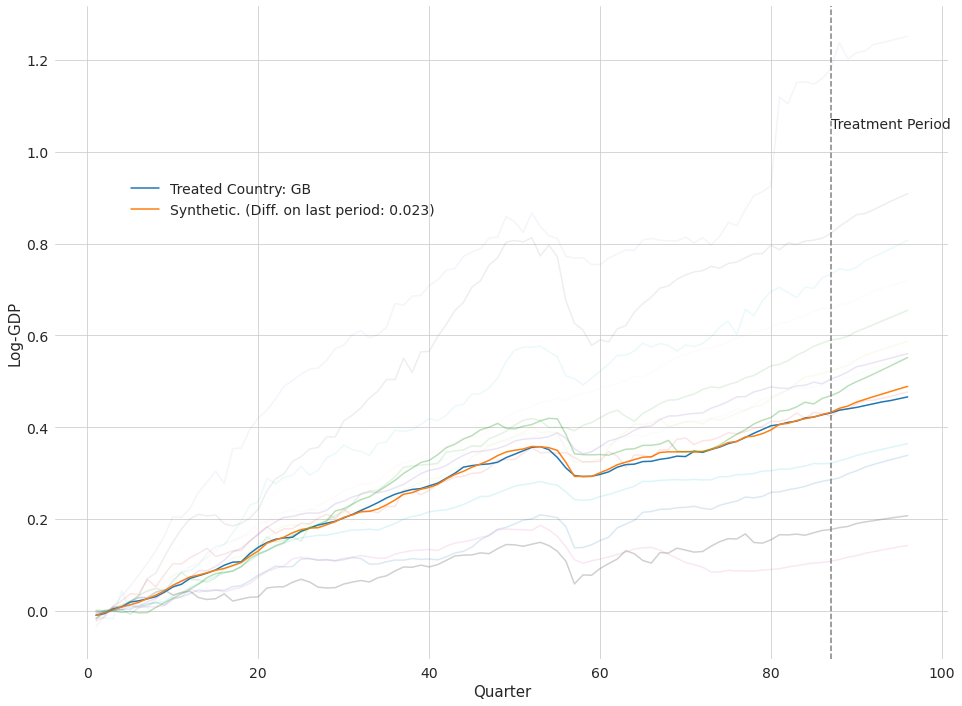

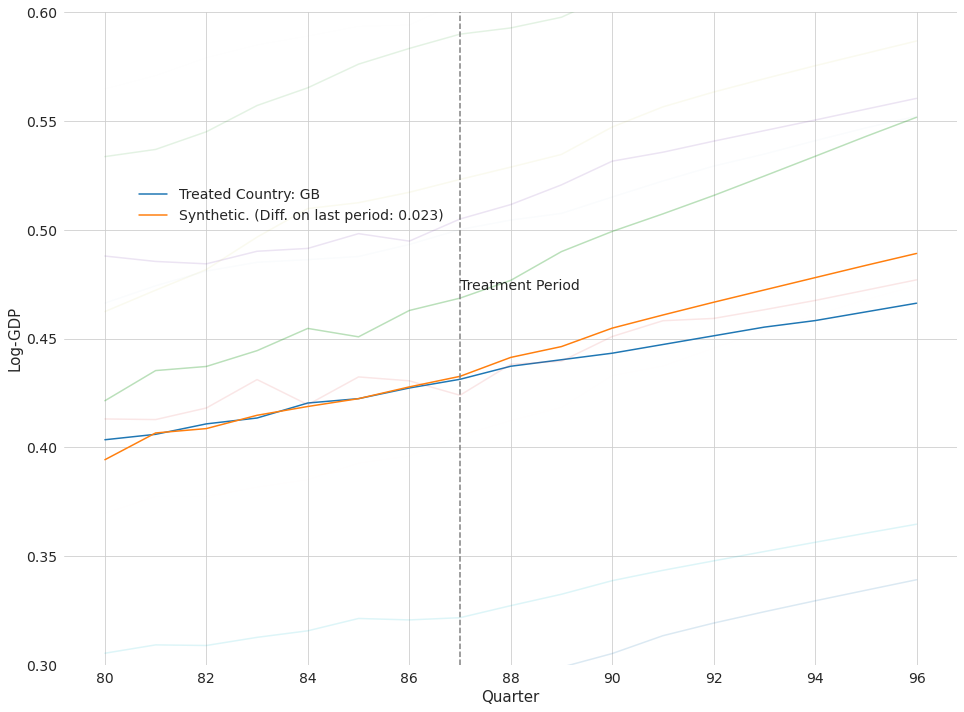

In [11]:
plot_results(df, result, treatment_period, caption="Figure 1.")
plot_results(df, result, 87, periods=range(80, 97), ylim=(0.3, 0.6))

### 2.2 Robustness Checks

## 3 Conclusion